In [1]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd



# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


#loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

#print(loaded_data)
#print(frequency)
#print(forecast_horizon)
#print(contain_missing_values)
#print(contain_equal_length)

In [2]:
Phase_2 = convert_tsf_to_dataframe("phase_2_data.tsf")
Phase_2

(   series_name     start_timestamp  \
 0    Building0 2016-07-03 21:30:00   
 1    Building1 2019-01-09 23:15:00   
 2    Building3 2016-03-01 04:15:00   
 3    Building4 2019-07-03 04:45:00   
 4    Building5 2019-07-25 23:00:00   
 5    Building6 2019-07-25 01:45:00   
 6       Solar0 2020-04-25 14:00:00   
 7       Solar1 2018-12-31 13:00:00   
 8       Solar2 2019-06-05 14:00:00   
 9       Solar3 2019-06-05 14:00:00   
 10      Solar4 2019-06-05 14:00:00   
 11      Solar5 2019-01-15 13:00:00   
 
                                          series_value  
 0   [283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606...  
 1   [8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,...  
 2   [1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293....  
 3   [2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ...  
 4   [30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33....  
 5   [36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35....  
 6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
 7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [3]:
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = Phase_2

In [4]:
loaded_data

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,"[283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606..."
1,Building1,2019-01-09 23:15:00,"[8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,..."
2,Building3,2016-03-01 04:15:00,"[1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293...."
3,Building4,2019-07-03 04:45:00,"[2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ..."
4,Building5,2019-07-25 23:00:00,"[30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33...."
5,Building6,2019-07-25 01:45:00,"[36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35...."
6,Solar0,2020-04-25 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Solar1,2018-12-31 13:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Solar2,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Solar3,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Data wrangling for training dataset

In [5]:
dataset = loaded_data.explode('series_value')
dataset

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,606.0
0,Building0,2016-07-03 21:30:00,606.0
...,...,...,...
11,Solar5,2019-01-15 13:00:00,13.47
11,Solar5,2019-01-15 13:00:00,15.93
11,Solar5,2019-01-15 13:00:00,17.11
11,Solar5,2019-01-15 13:00:00,18.29


## Solar 0

In [6]:
solar_0 = dataset.loc[dataset['series_name']=='Solar0']
solar_0

,series_name,start_timestamp,series_value
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
...,...,...,...
6,Solar0,2020-04-25 14:00:00,18.53
6,Solar0,2020-04-25 14:00:00,22.23
6,Solar0,2020-04-25 14:00:00,23.39
6,Solar0,2020-04-25 14:00:00,24.56


In [7]:
import datetime

# Input start date
start_date_str = '25/04/2020 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][6])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [8]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_0['start_timestamp']=datetime_column

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/2088926728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_0['start_timestamp']=datetime_column


In [9]:
solar_0 = solar_0.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [10]:
solar_0 = solar_0[solar_0.power_output != "NaN"]

In [11]:
solar_0["power_output"] = pd.to_numeric(solar_0["power_output"])
solar_0

,solar_no,timestamp,power_output
6,Solar0,2020-04-25 14:00:00,0.00
6,Solar0,2020-04-25 14:15:00,0.00
6,Solar0,2020-04-25 14:30:00,0.00
6,Solar0,2020-04-25 14:45:00,0.00
6,Solar0,2020-04-25 15:00:00,0.00
...,...,...,...
6,Solar0,2020-10-31 22:45:00,18.53
6,Solar0,2020-10-31 23:00:00,22.23
6,Solar0,2020-10-31 23:15:00,23.39
6,Solar0,2020-10-31 23:30:00,24.56


## Solar 1 

In [12]:
solar_1 = dataset.loc[dataset['series_name']=='Solar1']
solar_1

,series_name,start_timestamp,series_value
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
...,...,...,...
7,Solar1,2018-12-31 13:00:00,4.96
7,Solar1,2018-12-31 13:00:00,5.88
7,Solar1,2018-12-31 13:00:00,6.31
7,Solar1,2018-12-31 13:00:00,6.73


In [13]:
import datetime

# Input start date
start_date_str = '31/12/2018 13:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][7])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [14]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_1['start_timestamp']=datetime_column

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/1406122542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_1['start_timestamp']=datetime_column


In [15]:
solar_1 = solar_1.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [16]:
solar_1 = solar_1[solar_1.power_output != "NaN"]

In [17]:
solar_1["power_output"] = pd.to_numeric(solar_1["power_output"])
solar_1

,solar_no,timestamp,power_output
7,Solar1,2018-12-31 13:00:00,0.00
7,Solar1,2018-12-31 13:15:00,0.00
7,Solar1,2018-12-31 13:30:00,0.00
7,Solar1,2018-12-31 13:45:00,0.00
7,Solar1,2018-12-31 14:00:00,0.00
...,...,...,...
7,Solar1,2020-10-31 22:45:00,4.96
7,Solar1,2020-10-31 23:00:00,5.88
7,Solar1,2020-10-31 23:15:00,6.31
7,Solar1,2020-10-31 23:30:00,6.73


## Solar 2 

In [18]:
solar_2 = dataset.loc[dataset['series_name']=='Solar2']
solar_2

,series_name,start_timestamp,series_value
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
...,...,...,...
8,Solar2,2019-06-05 14:00:00,4.73
8,Solar2,2019-06-05 14:00:00,5.64
8,Solar2,2019-06-05 14:00:00,5.99
8,Solar2,2019-06-05 14:00:00,6.35


In [19]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][8])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [20]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_2['start_timestamp']=datetime_column

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/3880390651.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_2['start_timestamp']=datetime_column


In [21]:
solar_2 = solar_2.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [22]:
solar_2 = solar_2[solar_2.power_output != "NaN"]

In [23]:
solar_2["power_output"] = pd.to_numeric(solar_2["power_output"])
solar_2

,solar_no,timestamp,power_output
8,Solar2,2019-06-05 14:00:00,0.00
8,Solar2,2019-06-05 14:15:00,0.00
8,Solar2,2019-06-05 14:30:00,0.00
8,Solar2,2019-06-05 14:45:00,0.00
8,Solar2,2019-06-05 15:00:00,0.00
...,...,...,...
8,Solar2,2020-10-31 22:45:00,4.73
8,Solar2,2020-10-31 23:00:00,5.64
8,Solar2,2020-10-31 23:15:00,5.99
8,Solar2,2020-10-31 23:30:00,6.35


## Solar 3

In [24]:
solar_3 = dataset.loc[dataset['series_name']=='Solar3']
solar_3

,series_name,start_timestamp,series_value
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
...,...,...,...
9,Solar3,2019-06-05 14:00:00,4.31
9,Solar3,2019-06-05 14:00:00,5.08
9,Solar3,2019-06-05 14:00:00,5.45
9,Solar3,2019-06-05 14:00:00,5.83


In [25]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][9])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [26]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_3['start_timestamp']=datetime_column

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/1532600260.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_3['start_timestamp']=datetime_column


In [27]:
solar_3 = solar_3.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [28]:
solar_3 = solar_3[solar_3.power_output != "NaN"]

In [29]:
solar_3["power_output"] = pd.to_numeric(solar_3["power_output"])
solar_3

,solar_no,timestamp,power_output
9,Solar3,2019-06-05 14:00:00,0.00
9,Solar3,2019-06-05 14:15:00,0.00
9,Solar3,2019-06-05 14:30:00,0.00
9,Solar3,2019-06-05 14:45:00,0.00
9,Solar3,2019-06-05 15:00:00,0.00
...,...,...,...
9,Solar3,2020-10-31 22:45:00,4.31
9,Solar3,2020-10-31 23:00:00,5.08
9,Solar3,2020-10-31 23:15:00,5.45
9,Solar3,2020-10-31 23:30:00,5.83


## Solar 4

In [30]:
solar_4 = dataset.loc[dataset['series_name']=='Solar4']
solar_4

,series_name,start_timestamp,series_value
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
...,...,...,...
10,Solar4,2019-06-05 14:00:00,2.84
10,Solar4,2019-06-05 14:00:00,3.4
10,Solar4,2019-06-05 14:00:00,3.62
10,Solar4,2019-06-05 14:00:00,3.85


In [31]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][10])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [32]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_4['start_timestamp']=datetime_column

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/3380562403.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_4['start_timestamp']=datetime_column


In [33]:
solar_4 = solar_4.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [34]:
solar_4 = solar_4[solar_4.power_output != "NaN"]

In [35]:
solar_4["power_output"] = pd.to_numeric(solar_4["power_output"])
solar_4

,solar_no,timestamp,power_output
10,Solar4,2019-06-05 14:00:00,0.00
10,Solar4,2019-06-05 14:15:00,0.00
10,Solar4,2019-06-05 14:30:00,0.00
10,Solar4,2019-06-05 14:45:00,0.00
10,Solar4,2019-06-05 15:00:00,0.00
...,...,...,...
10,Solar4,2020-10-31 22:45:00,2.84
10,Solar4,2020-10-31 23:00:00,3.40
10,Solar4,2020-10-31 23:15:00,3.62
10,Solar4,2020-10-31 23:30:00,3.85


## Solar 5

In [36]:
solar_5 = dataset.loc[dataset['series_name']=='Solar5']
solar_5

,series_name,start_timestamp,series_value
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
...,...,...,...
11,Solar5,2019-01-15 13:00:00,13.47
11,Solar5,2019-01-15 13:00:00,15.93
11,Solar5,2019-01-15 13:00:00,17.11
11,Solar5,2019-01-15 13:00:00,18.29


In [37]:
import datetime

# Input start date
start_date_str = '15/01/2019 13:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][11])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [38]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_5['start_timestamp']=datetime_column

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/1564464354.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_5['start_timestamp']=datetime_column


In [39]:
solar_5 = solar_5.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [40]:
solar_5 = solar_5[solar_5.power_output != "NaN"]

In [41]:
solar_5["power_output"] = pd.to_numeric(solar_5["power_output"])
solar_5

,solar_no,timestamp,power_output
11,Solar5,2019-01-15 13:00:00,0.00
11,Solar5,2019-01-15 13:15:00,0.00
11,Solar5,2019-01-15 13:30:00,0.00
11,Solar5,2019-01-15 13:45:00,0.00
11,Solar5,2019-01-15 14:00:00,0.00
...,...,...,...
11,Solar5,2020-10-31 22:45:00,13.47
11,Solar5,2020-10-31 23:00:00,15.93
11,Solar5,2020-10-31 23:15:00,17.11
11,Solar5,2020-10-31 23:30:00,18.29


## Combining Weather data with our solar dataset

### Indexing timestamp

In [42]:
solar_0['timestamp'] = solar_0['timestamp'] + pd.Timedelta(hours=10)
solar_1['timestamp'] = solar_1['timestamp'] + pd.Timedelta(hours=10)
solar_2['timestamp'] = solar_2['timestamp'] + pd.Timedelta(hours=10)
solar_3['timestamp'] = solar_3['timestamp'] + pd.Timedelta(hours=10)
solar_4['timestamp'] = solar_4['timestamp'] + pd.Timedelta(hours=10)
solar_5['timestamp'] = solar_5['timestamp'] + pd.Timedelta(hours=10)

In [43]:
solar_0 = solar_0.set_index(pd.DatetimeIndex(solar_0['timestamp'])).drop(solar_0.columns[1], axis=1)
solar_0

,solar_no,power_output
timestamp,,
2020-04-26 00:00:00,Solar0,0.00
2020-04-26 00:15:00,Solar0,0.00
2020-04-26 00:30:00,Solar0,0.00
2020-04-26 00:45:00,Solar0,0.00
2020-04-26 01:00:00,Solar0,0.00
...,...,...
2020-11-01 08:45:00,Solar0,18.53
2020-11-01 09:00:00,Solar0,22.23
2020-11-01 09:15:00,Solar0,23.39


In [44]:
solar_1 = solar_1.set_index(pd.DatetimeIndex(solar_1['timestamp'])).drop(solar_1.columns[1], axis=1)
solar_1

,solar_no,power_output
timestamp,,
2018-12-31 23:00:00,Solar1,0.00
2018-12-31 23:15:00,Solar1,0.00
2018-12-31 23:30:00,Solar1,0.00
2018-12-31 23:45:00,Solar1,0.00
2019-01-01 00:00:00,Solar1,0.00
...,...,...
2020-11-01 08:45:00,Solar1,4.96
2020-11-01 09:00:00,Solar1,5.88
2020-11-01 09:15:00,Solar1,6.31


In [45]:
solar_2 = solar_2.set_index(pd.DatetimeIndex(solar_2['timestamp'])).drop(solar_2.columns[1], axis=1)
solar_2

,solar_no,power_output
timestamp,,
2019-06-06 00:00:00,Solar2,0.00
2019-06-06 00:15:00,Solar2,0.00
2019-06-06 00:30:00,Solar2,0.00
2019-06-06 00:45:00,Solar2,0.00
2019-06-06 01:00:00,Solar2,0.00
...,...,...
2020-11-01 08:45:00,Solar2,4.73
2020-11-01 09:00:00,Solar2,5.64
2020-11-01 09:15:00,Solar2,5.99


In [46]:
solar_3 = solar_3.set_index(pd.DatetimeIndex(solar_3['timestamp'])).drop(solar_3.columns[1], axis=1)
solar_3

,solar_no,power_output
timestamp,,
2019-06-06 00:00:00,Solar3,0.00
2019-06-06 00:15:00,Solar3,0.00
2019-06-06 00:30:00,Solar3,0.00
2019-06-06 00:45:00,Solar3,0.00
2019-06-06 01:00:00,Solar3,0.00
...,...,...
2020-11-01 08:45:00,Solar3,4.31
2020-11-01 09:00:00,Solar3,5.08
2020-11-01 09:15:00,Solar3,5.45


In [47]:
solar_4 = solar_4.set_index(pd.DatetimeIndex(solar_4['timestamp'])).drop(solar_4.columns[1], axis=1)
solar_4

,solar_no,power_output
timestamp,,
2019-06-06 00:00:00,Solar4,0.00
2019-06-06 00:15:00,Solar4,0.00
2019-06-06 00:30:00,Solar4,0.00
2019-06-06 00:45:00,Solar4,0.00
2019-06-06 01:00:00,Solar4,0.00
...,...,...
2020-11-01 08:45:00,Solar4,2.84
2020-11-01 09:00:00,Solar4,3.40
2020-11-01 09:15:00,Solar4,3.62


In [48]:
solar_5 = solar_5.set_index(pd.DatetimeIndex(solar_5['timestamp'])).drop(solar_5.columns[1], axis=1)
solar_5

,solar_no,power_output
timestamp,,
2019-01-15 23:00:00,Solar5,0.00
2019-01-15 23:15:00,Solar5,0.00
2019-01-15 23:30:00,Solar5,0.00
2019-01-15 23:45:00,Solar5,0.00
2019-01-16 00:00:00,Solar5,0.00
...,...,...
2020-11-01 08:45:00,Solar5,13.47
2020-11-01 09:00:00,Solar5,15.93
2020-11-01 09:15:00,Solar5,17.11


### Merging weather and dataset for training

In [50]:
weather = pd.read_csv("monash_weather.csv")
weather

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
1,2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2,2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
3,2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
4,2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100052,2021-05-31 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
100053,2021-05-31 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
100054,2021-05-31 22:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00
100055,2021-05-31 23:00:00,"(-37.91, 145.13)",era5,69.59,10.0,9.83,3.88,5.60,102077.12,0.66,80.46,296.20,1.00


In [51]:
weather['datetime (UTC)'] = pd.to_datetime(weather['datetime (UTC)'])

weather['datetime (UTC)'] = weather['datetime (UTC)'] + pd.Timedelta(hours=10)
weather

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2010-01-01 10:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
1,2010-01-01 11:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2,2010-01-01 12:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
3,2010-01-01 13:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
4,2010-01-01 14:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100052,2021-06-01 06:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
100053,2021-06-01 07:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
100054,2021-06-01 08:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00
100055,2021-06-01 09:00:00,"(-37.91, 145.13)",era5,69.59,10.0,9.83,3.88,5.60,102077.12,0.66,80.46,296.20,1.00


In [52]:
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather

,"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,,,,,
2010-01-01 10:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
2010-01-01 11:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2010-01-01 12:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
2010-01-01 13:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
2010-01-01 14:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01 06:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
2021-06-01 07:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
2021-06-01 08:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00


In [53]:
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather

,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,,,
2010-01-01 10:00:00,69.6,10.0,18.3,16.4,2.6,101046.4,0.9,287.0,408.4,1.0
2010-01-01 10:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 11:00:00,69.6,10.0,18.7,16.3,2.9,101038.0,0.9,360.8,411.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,69.6,10.0,9.8,3.9,5.6,102077.1,0.7,80.5,296.2,1.0
2021-06-01 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
weather.isna().sum()

model elevation (surface)            300168
utc_offset (hrs)                     300168
temperature (degC)                   300168
dewpoint_temperature (degC)          300168
wind_speed (m/s)                     300168
mean_sea_level_pressure (Pa)         300168
relative_humidity ((0-1))            300168
surface_solar_radiation (W/m^2)      300168
surface_thermal_radiation (W/m^2)    300168
total_cloud_cover (0-1)              300168
dtype: int64

In [55]:
weather = weather.interpolate(method='linear') #Input NaN
weather

,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,,,
2010-01-01 10:00:00,69.6,10.0,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 10:15:00,69.6,10.0,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 10:30:00,69.6,10.0,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 10:45:00,69.6,10.0,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 11:00:00,69.6,10.0,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,69.6,10.0,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-06-01 09:15:00,69.6,10.0,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-06-01 09:30:00,69.6,10.0,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [56]:
weather.isna().sum()

model elevation (surface)            0
utc_offset (hrs)                     0
temperature (degC)                   0
dewpoint_temperature (degC)          0
wind_speed (m/s)                     0
mean_sea_level_pressure (Pa)         0
relative_humidity ((0-1))            0
surface_solar_radiation (W/m^2)      0
surface_thermal_radiation (W/m^2)    0
total_cloud_cover (0-1)              0
dtype: int64

In [57]:
weather.index.names = ['timestamp']
weather

,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2010-01-01 10:00:00,69.6,10.0,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 10:15:00,69.6,10.0,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 10:30:00,69.6,10.0,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 10:45:00,69.6,10.0,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 11:00:00,69.6,10.0,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,69.6,10.0,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-06-01 09:15:00,69.6,10.0,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-06-01 09:30:00,69.6,10.0,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [58]:
solar0 = pd.merge(solar_0, weather, left_index=True, right_index=True)
solar0

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2020-04-26 00:00:00,Solar0,0.00,69.6,10.0,16.100,13.600,6.300,101156.400,0.800,0.0,366.900,1.000
2020-04-26 00:15:00,Solar0,0.00,69.6,10.0,16.075,13.725,6.175,101130.075,0.825,0.0,367.325,1.000
2020-04-26 00:30:00,Solar0,0.00,69.6,10.0,16.050,13.850,6.050,101103.750,0.850,0.0,367.750,1.000
2020-04-26 00:45:00,Solar0,0.00,69.6,10.0,16.025,13.975,5.925,101077.425,0.875,0.0,368.175,1.000
2020-04-26 01:00:00,Solar0,0.00,69.6,10.0,16.000,14.100,5.800,101051.100,0.900,0.0,368.600,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar0,18.53,69.6,10.0,13.850,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar0,22.23,69.6,10.0,14.000,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar0,23.39,69.6,10.0,14.100,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


In [59]:
solar1 = pd.merge(solar_1, weather, left_index=True, right_index=True)
solar1

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2018-12-31 23:00:00,Solar1,0.00,69.6,10.0,16.30,12.400,3.100,101292.900,0.800,0.0,330.600,0.000
2018-12-31 23:15:00,Solar1,0.00,69.6,10.0,16.10,12.425,3.000,101283.875,0.800,0.0,329.575,0.025
2018-12-31 23:30:00,Solar1,0.00,69.6,10.0,15.90,12.450,2.900,101274.850,0.800,0.0,328.550,0.050
2018-12-31 23:45:00,Solar1,0.00,69.6,10.0,15.70,12.475,2.800,101265.825,0.800,0.0,327.525,0.075
2019-01-01 00:00:00,Solar1,0.00,69.6,10.0,15.50,12.500,2.700,101256.800,0.800,0.0,326.500,0.100
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar1,4.96,69.6,10.0,13.85,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar1,5.88,69.6,10.0,14.00,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar1,6.31,69.6,10.0,14.10,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


In [60]:
solar2 = pd.merge(solar_2, weather, left_index=True, right_index=True)
solar2

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2019-06-06 00:00:00,Solar2,0.00,69.6,10.0,10.10,7.100,4.700,100914.100,0.800,0.0,346.500,1.000
2019-06-06 00:15:00,Solar2,0.00,69.6,10.0,10.15,7.200,4.700,100910.350,0.800,0.0,348.525,1.000
2019-06-06 00:30:00,Solar2,0.00,69.6,10.0,10.20,7.300,4.700,100906.600,0.800,0.0,350.550,1.000
2019-06-06 00:45:00,Solar2,0.00,69.6,10.0,10.25,7.400,4.700,100902.850,0.800,0.0,352.575,1.000
2019-06-06 01:00:00,Solar2,0.00,69.6,10.0,10.30,7.500,4.700,100899.100,0.800,0.0,354.600,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar2,4.73,69.6,10.0,13.85,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar2,5.64,69.6,10.0,14.00,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar2,5.99,69.6,10.0,14.10,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


In [61]:
solar3 = pd.merge(solar_3, weather, left_index=True, right_index=True)
solar3

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2019-06-06 00:00:00,Solar3,0.00,69.6,10.0,10.10,7.100,4.700,100914.100,0.800,0.0,346.500,1.000
2019-06-06 00:15:00,Solar3,0.00,69.6,10.0,10.15,7.200,4.700,100910.350,0.800,0.0,348.525,1.000
2019-06-06 00:30:00,Solar3,0.00,69.6,10.0,10.20,7.300,4.700,100906.600,0.800,0.0,350.550,1.000
2019-06-06 00:45:00,Solar3,0.00,69.6,10.0,10.25,7.400,4.700,100902.850,0.800,0.0,352.575,1.000
2019-06-06 01:00:00,Solar3,0.00,69.6,10.0,10.30,7.500,4.700,100899.100,0.800,0.0,354.600,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar3,4.31,69.6,10.0,13.85,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar3,5.08,69.6,10.0,14.00,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar3,5.45,69.6,10.0,14.10,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


In [62]:
solar4 = pd.merge(solar_4, weather, left_index=True, right_index=True)
solar4

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2019-06-06 00:00:00,Solar4,0.00,69.6,10.0,10.10,7.100,4.700,100914.100,0.800,0.0,346.500,1.000
2019-06-06 00:15:00,Solar4,0.00,69.6,10.0,10.15,7.200,4.700,100910.350,0.800,0.0,348.525,1.000
2019-06-06 00:30:00,Solar4,0.00,69.6,10.0,10.20,7.300,4.700,100906.600,0.800,0.0,350.550,1.000
2019-06-06 00:45:00,Solar4,0.00,69.6,10.0,10.25,7.400,4.700,100902.850,0.800,0.0,352.575,1.000
2019-06-06 01:00:00,Solar4,0.00,69.6,10.0,10.30,7.500,4.700,100899.100,0.800,0.0,354.600,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar4,2.84,69.6,10.0,13.85,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar4,3.40,69.6,10.0,14.00,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar4,3.62,69.6,10.0,14.10,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


In [63]:
solar5 = pd.merge(solar_5, weather, left_index=True, right_index=True)
solar5

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2019-01-15 23:00:00,Solar5,0.00,69.6,10.0,22.700,15.500,1.600,100821.700,0.600,0.0,346.000,0.000
2019-01-15 23:15:00,Solar5,0.00,69.6,10.0,22.575,15.525,2.175,100839.525,0.625,0.0,345.975,0.000
2019-01-15 23:30:00,Solar5,0.00,69.6,10.0,22.450,15.550,2.750,100857.350,0.650,0.0,345.950,0.000
2019-01-15 23:45:00,Solar5,0.00,69.6,10.0,22.325,15.575,3.325,100875.175,0.675,0.0,345.925,0.000
2019-01-16 00:00:00,Solar5,0.00,69.6,10.0,22.200,15.600,3.900,100893.000,0.700,0.0,345.900,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar5,13.47,69.6,10.0,13.850,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar5,15.93,69.6,10.0,14.000,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar5,17.11,69.6,10.0,14.100,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


## Data analysis

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(solar):
    plt.figure(figsize=(16, 6))
    heatmap = sns.heatmap(solar.corr(), vmin=-1, vmax=1, annot=True,cmap="Blues")
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=12);

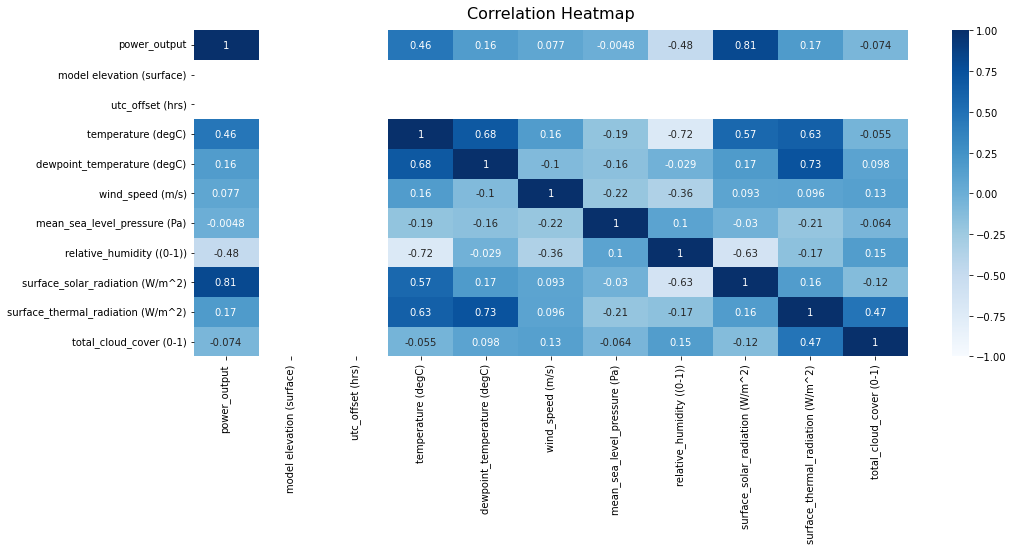

In [65]:
heatmap(solar2)

- So basically there are 3 most important variables notwithstanding the solar panel, such as Relative humidity, surface_solar_radiation and Temperature

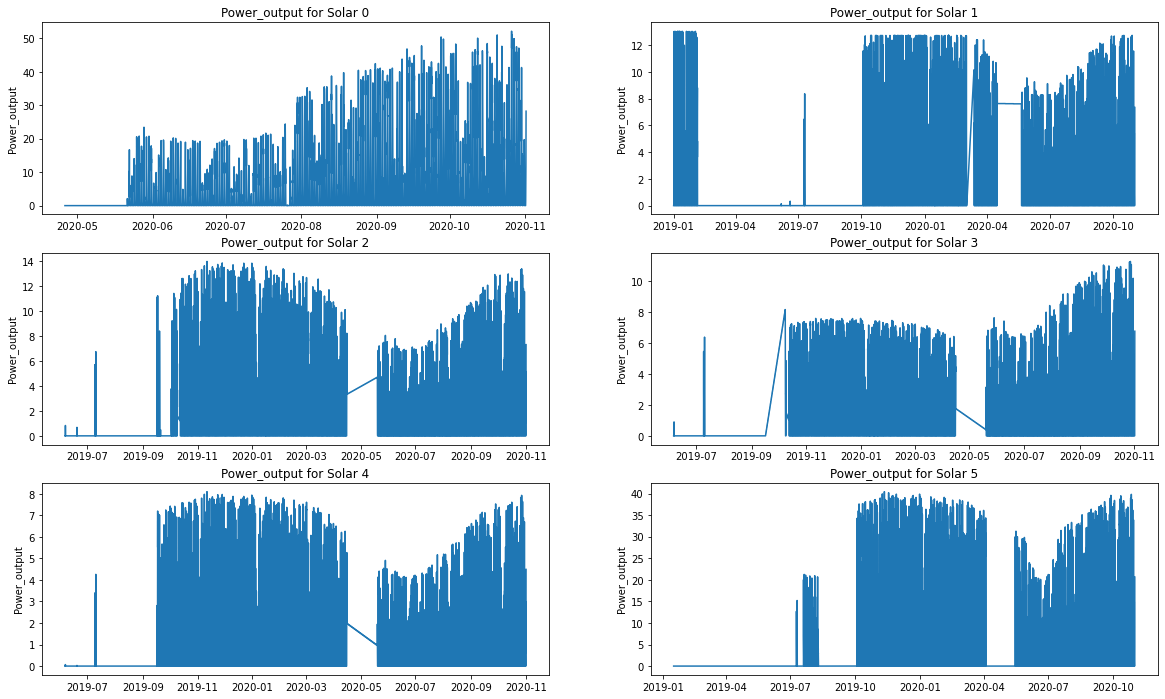

In [66]:
fig, ax = plt.subplots(3, 2,figsize=(20, 12))

ax[0, 0].plot(solar0.index,solar0['power_output'])
ax[0, 1].plot(solar1.index,solar1['power_output'])
ax[1, 0].plot(solar2.index,solar2['power_output'])
ax[1, 1].plot(solar3.index,solar3['power_output'])
ax[2, 0].plot(solar4.index,solar4['power_output'])
ax[2, 1].plot(solar5.index,solar5['power_output'])

ax[0, 0].set_title('Power_output for Solar 0')
ax[0, 1].set_title('Power_output for Solar 1')
ax[1, 0].set_title('Power_output for Solar 2')
ax[1, 1].set_title('Power_output for Solar 3')
ax[2, 0].set_title('Power_output for Solar 4')
ax[2, 1].set_title('Power_output for Solar 5')

ax[0, 0].set_ylabel('Power_output')
ax[0, 1].set_ylabel('Power_output')
ax[1, 0].set_ylabel('Power_output')
ax[1, 1].set_ylabel('Power_output')
ax[2, 0].set_ylabel('Power_output')
ax[2, 1].set_ylabel('Power_output')

plt.show()

## Data wrangling for test dataset

In [67]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd



# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


In [68]:
test_data = convert_tsf_to_dataframe("nov_data.tsf")
test_data

(   series_name     start_timestamp  \
 0    Building0 2016-07-03 21:30:00   
 1    Building1 2019-01-09 23:15:00   
 2    Building3 2016-03-01 04:15:00   
 3    Building4 2019-07-03 04:45:00   
 4    Building5 2019-07-25 23:00:00   
 5    Building6 2019-07-25 01:45:00   
 6       Solar0 2020-04-25 14:00:00   
 7       Solar1 2018-12-31 13:00:00   
 8       Solar2 2019-06-05 14:00:00   
 9       Solar3 2019-06-05 14:00:00   
 10      Solar4 2019-06-05 14:00:00   
 11      Solar5 2019-01-15 13:00:00   
 
                                          series_value  
 0   [283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606...  
 1   [8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,...  
 2   [1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293....  
 3   [2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ...  
 4   [30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33....  
 5   [36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35....  
 6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
 7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [69]:
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = test_data

In [70]:
nov_test = loaded_data.explode('series_value')
nov_test

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,606.0
0,Building0,2016-07-03 21:30:00,606.0
...,...,...,...
11,Solar5,2019-01-15 13:00:00,9.86
11,Solar5,2019-01-15 13:00:00,6.22
11,Solar5,2019-01-15 13:00:00,7.14
11,Solar5,2019-01-15 13:00:00,5.64


In [71]:
solar_0_test = nov_test.loc[nov_test['series_name']=='Solar0']
solar_1_test = nov_test.loc[nov_test['series_name']=='Solar1']
solar_2_test = nov_test.loc[nov_test['series_name']=='Solar2']
solar_3_test = nov_test.loc[nov_test['series_name']=='Solar3']
solar_4_test = nov_test.loc[nov_test['series_name']=='Solar4']
solar_5_test = nov_test.loc[nov_test['series_name']=='Solar5']

### Merging weather and test data function

In [72]:
def convert_for_test_data(start_date_str,solar):
    
    end_date_str = '30/11/2020 23:45:00'
# Convert start and end date strings to datetime objects
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
    datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')
    solar['start_timestamp']=datetime_column
    
    #Change column names and the types of variables
    solar = solar.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
    solar = solar[solar.power_output != "NaN"]
    solar["power_output"] = pd.to_numeric(solar["power_output"])
    
    #Increment by 10 hours given the offset of 10 
    solar['timestamp'] = solar['timestamp'] + pd.Timedelta(hours=10)
    
    #index timestamp and sort the time for testing dataset
    solar = solar.set_index(pd.DatetimeIndex(solar['timestamp'])).drop(solar.columns[1], axis=1)
    solar = pd.merge(solar, weather, left_index=True, right_index=True)
    solar = solar[pd.Timestamp('2020-11-01 10:00:00'):pd.Timestamp('2020-12-01 09:45:00')]
    return solar

__Train data__------------------------------------

- Since Solar_0 starts on 25th April 2020, and there's no huge gap, we keep the original solar0 dataset for training. 
- We chose 1st Oct 2019 to be our starting timestamp for each solar because there is very huge gap in power_output prior to 1st Oct 2019 for solar 1 to solar 5

In [73]:
solar1 = solar1[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [74]:
solar2 = solar2[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [75]:
solar3 = solar3[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [76]:
solar4 = solar4[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [77]:
solar5 = solar5[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

#### Test data ------------------------------------------

In [78]:
solar_0_test = convert_for_test_data("2020-04-25 14:00:00",solar_0_test)
solar_1_test = convert_for_test_data("2018-12-31 13:00:00",solar_1_test)
solar_2_test = convert_for_test_data("2019-06-05 14:00:00",solar_2_test)
solar_3_test = convert_for_test_data("2019-06-05 14:00:00",solar_3_test)
solar_4_test = convert_for_test_data("2019-06-05 14:00:00",solar_4_test)
solar_5_test = convert_for_test_data("2019-01-15 13:00:00",solar_5_test)

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/1417913438.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar['start_timestamp']=datetime_column


## Training models

### Function to obtain results (R^2, MAE, RMSE)

In [79]:
def reg_model(model, solar_train, solar_test):
    '''Convenience function to fit an sklearn regression model and calculate the r2 score'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns
    
    X_train = solar_train.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    X_test = solar_test.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']
    
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

# Create a table of the various scores.
    results = pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return results

### Function to obtain predicted power_output

In [80]:
def reg_predicted(model, solar_train, solar_test):
    '''Convenience function to fit an sklearn regression model and calculate the r2 score'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns
    
    X_train = solar_train.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    X_test = solar_test.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']
    
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

# Create a table of the various scores.
    results = pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return testing_predictions

### Function to create comparison plot between actual and predicted values

In [81]:
def compare_1(model,solar,solar_test):
    lin_solar_pred = reg_predicted(model,solar,solar_test)
    d5 = {'Predicted': lin_solar_pred, 'Actual': solar_test['power_output']}
    df5 = pd.DataFrame(data=d5)
    df5 = df5.reset_index(0)
    df5 = df5.replace(df5['Predicted'].loc[df5['Predicted']<0].values[:],0)
    plt.rcParams["figure.figsize"] = [20, 10]
    plt.plot(df5['Actual'],df5['Predicted'],'r.')
    plt.plot(df5['Actual'],df5['Actual'])
    plt.title('Comparison between Predicted and Actual power_output')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    #plt.scatter(df5['timestamp'],df5['Predicted'], color='red',label="Predicted")
    #plt.scatter(df5['timestamp'],df5['Actual'], color='blue',label="Actual")
    #plt.legend()
    #plt.tick_params(axis='x', labelrotation = 45)
    plt.show()

## Random forest

In [83]:
from sklearn.ensemble import RandomForestRegressor

#Create a base regression model using the RandomForestRegressor
random_f_solar0 = reg_model(RandomForestRegressor(random_state=0),solar0,solar_0_test)
random_f_solar0

,R^2,RMSE,MAE
train,0.989930,1.004753,0.450621
test,0.784815,7.541011,4.408371


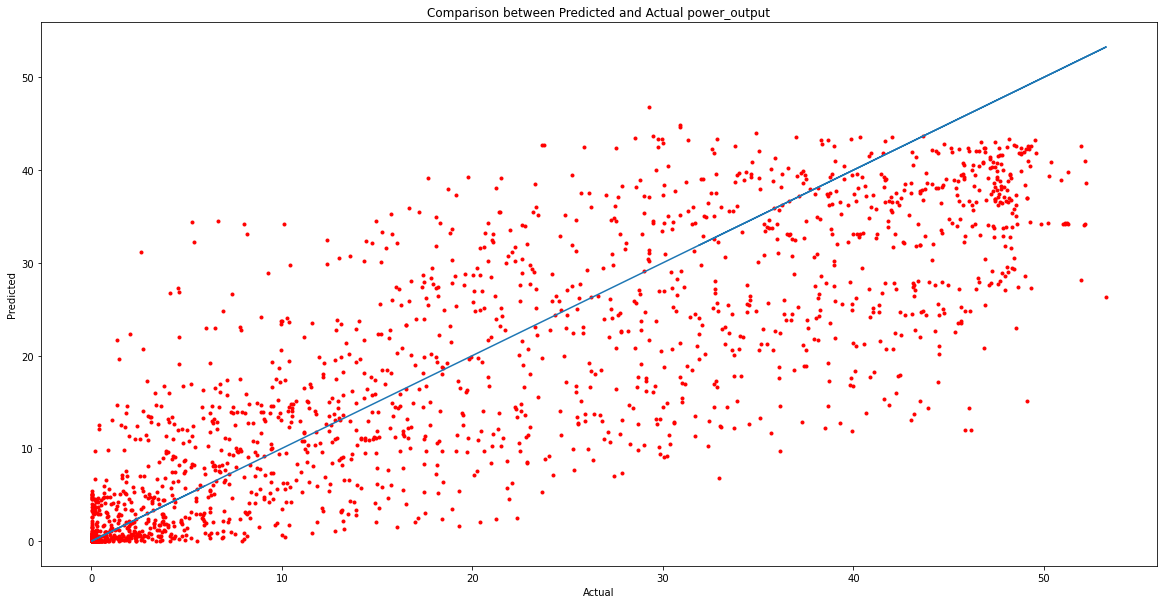

In [84]:
ran_0 = compare_1(RandomForestRegressor(random_state=0),solar0,solar_0_test)
ran_0

In [85]:
#solar11 = solar1.loc[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]
#solar11

In [86]:
random_f_solar1 = reg_model(RandomForestRegressor(random_state=0),solar1,solar_1_test)
random_f_solar1

,R^2,RMSE,MAE
train,0.989271,0.392334,0.220841
test,0.834788,1.735052,1.171144


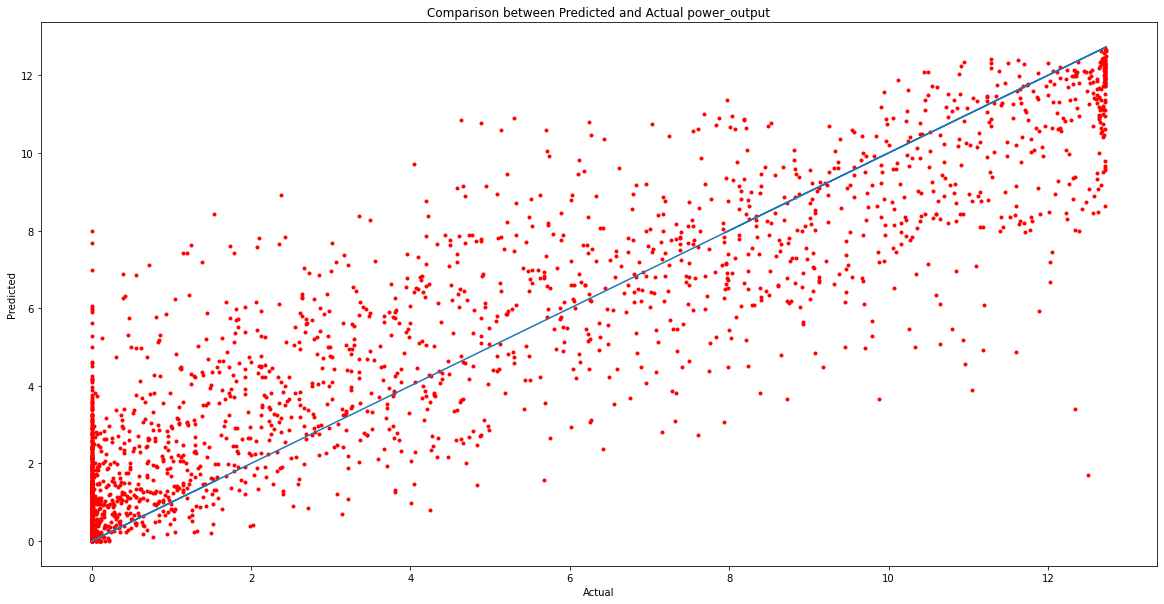

In [87]:
ran_1 = compare_1(RandomForestRegressor(random_state=0),solar1,solar_1_test)
ran_1

In [88]:
random_f_solar2 = reg_model(RandomForestRegressor(random_state=0),solar2,solar_2_test)
random_f_solar2

,R^2,RMSE,MAE
train,0.990893,0.323366,0.178345
test,0.859657,1.595570,0.984584


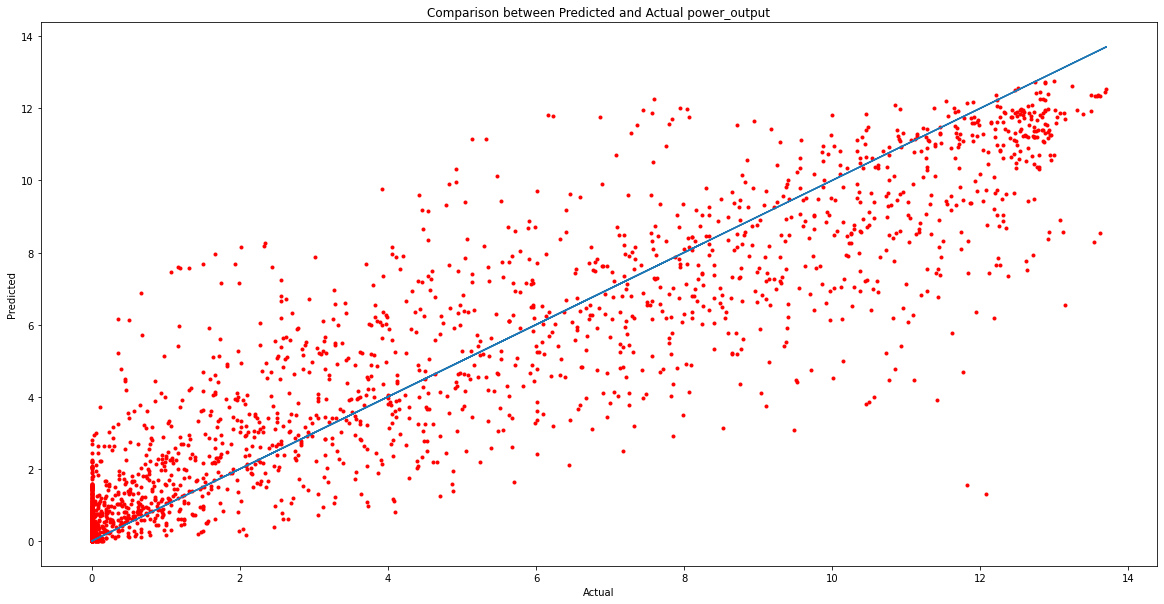

In [89]:
ran_2 = compare_1(RandomForestRegressor(random_state=0),solar2,solar_2_test)
ran_2

In [90]:
random_f_solar3 = reg_model(RandomForestRegressor(random_state=0),solar3,solar_3_test)
random_f_solar3

,R^2,RMSE,MAE
train,0.988719,0.261621,0.131213
test,0.729625,1.982997,1.282667


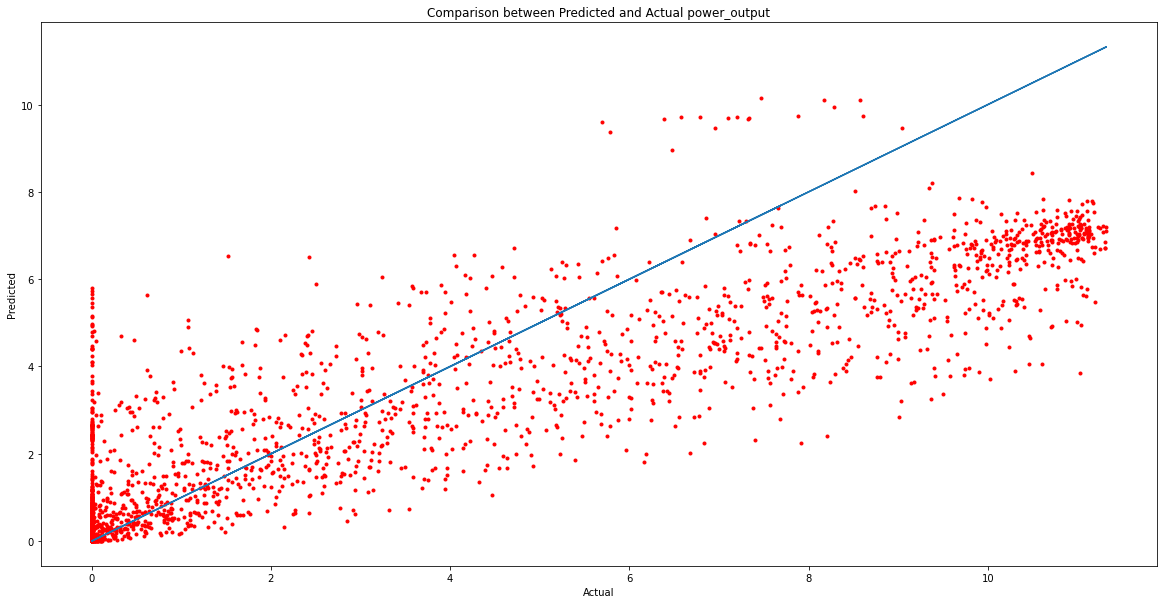

In [91]:
ran_3 = compare_1(RandomForestRegressor(random_state=0),solar3,solar_3_test)
ran_3

In [92]:
random_f_solar4 = reg_model(RandomForestRegressor(random_state=0),solar4,solar_4_test)
random_f_solar4

,R^2,RMSE,MAE
train,0.991311,0.190242,0.102831
test,0.856935,0.955555,0.597376


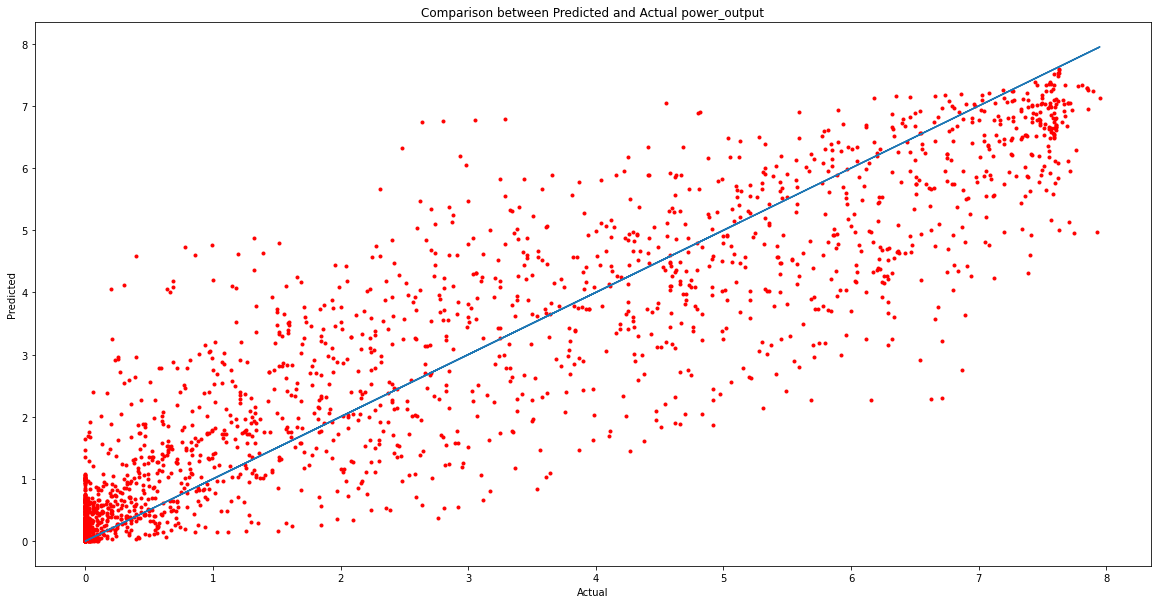

In [93]:
ran_4 = compare_1(RandomForestRegressor(random_state=0),solar4,solar_4_test)
ran_4

In [94]:
random_f_solar5 = reg_model(RandomForestRegressor(random_state=0),solar5,solar_5_test)
random_f_solar5

,R^2,RMSE,MAE
train,0.990468,1.040273,0.513375
test,0.855472,4.889772,2.716174


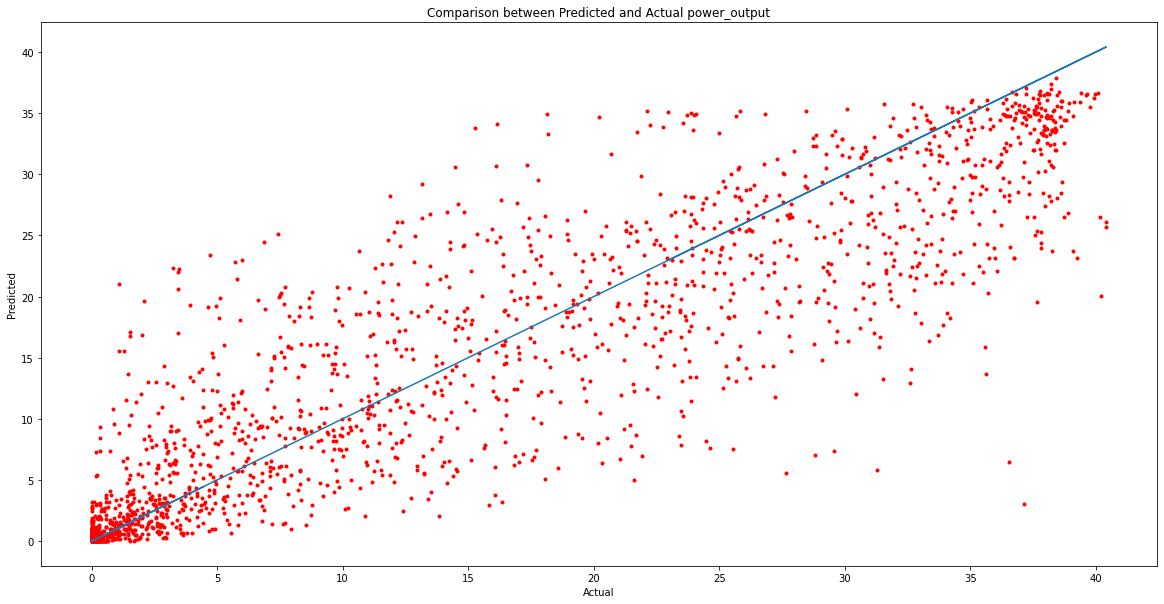

In [95]:
ran_5 = compare_1(RandomForestRegressor(),solar5,solar_5_test)
ran_5

## Feature selection

In [96]:
def feature_select(solar_train, solar_test):
    '''Selecting features'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2, f_regression
    
    X_train = solar_train.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    X_test = solar_test.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']
    
    features_new = SelectKBest(f_regression, k = "all")
    features_new.fit(X_train, Y_train)
    #pipe.get_feature_names_out()
    df_scores = pd.DataFrame(features_new.scores_)
    df_columns = pd.DataFrame(X_train.columns)
    # concatenate dataframes
    anova_scores = pd.concat([df_columns, df_scores],axis=1)
    anova_scores.columns = ['Feature_Name','Score']  # name output columns

    anova_scores.set_index('Feature_Name', inplace=True)
    anova_scores.sort_values(by='Score').plot(kind='barh', figsize=(8, 7)) # plot these as a bar plot

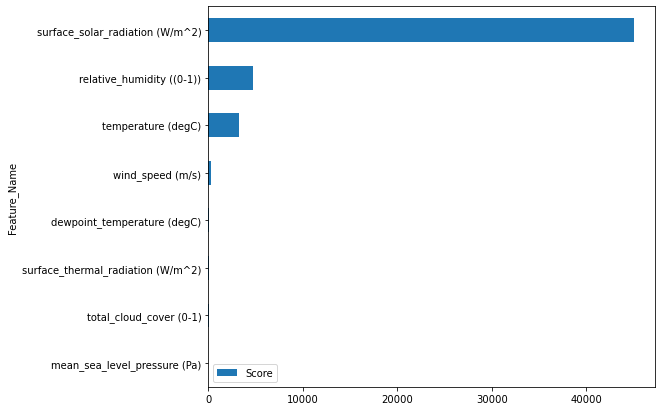

In [97]:
fea_solar_0 = feature_select(solar0,solar_0_test)
fea_solar_0

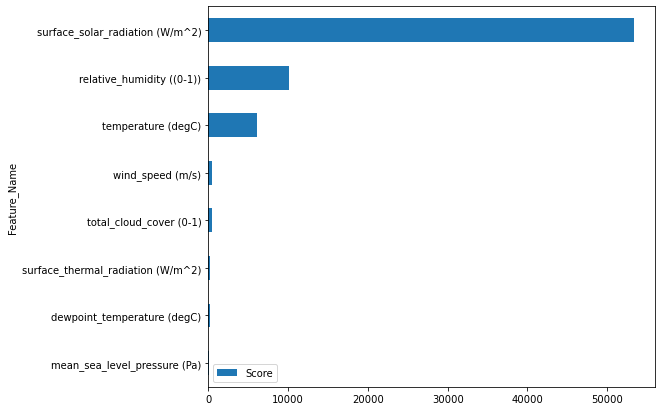

In [98]:
fea_solar_1 = feature_select(solar1,solar_1_test)
fea_solar_1

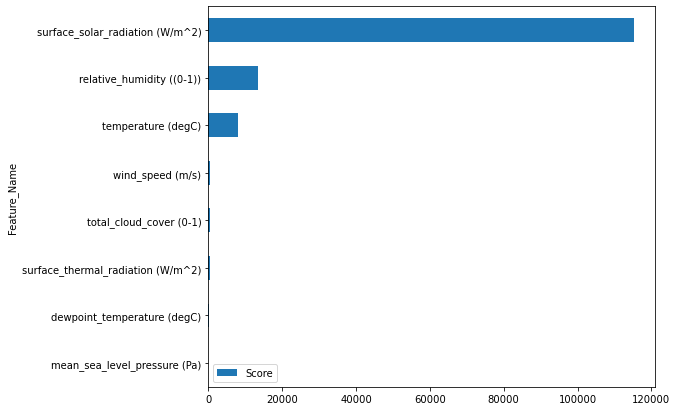

In [99]:
fea_solar_2 = feature_select(solar2,solar_2_test)
fea_solar_2

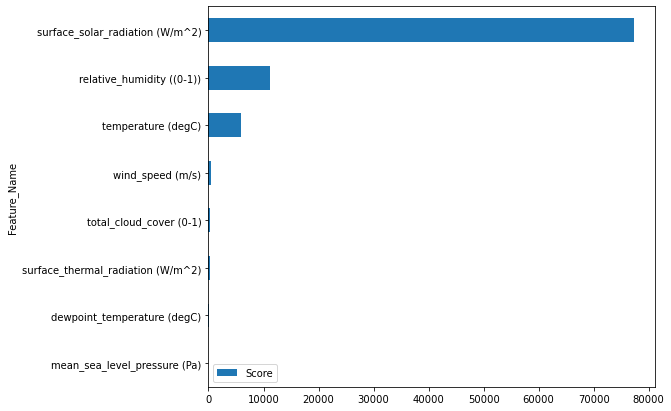

In [100]:
fea_solar_3 = feature_select(solar3,solar_3_test)
fea_solar_3

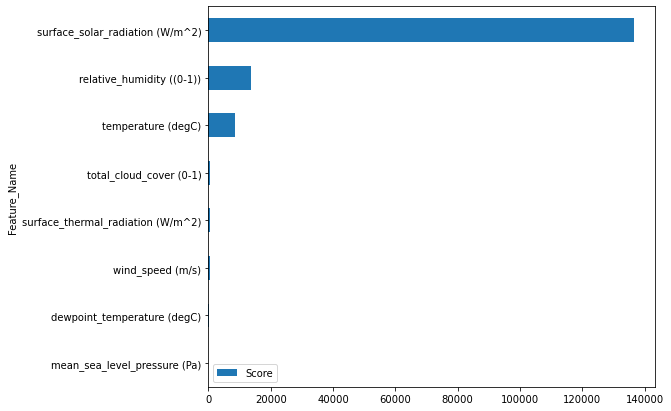

In [101]:
fea_solar_4 = feature_select(solar4,solar_4_test)
fea_solar_4

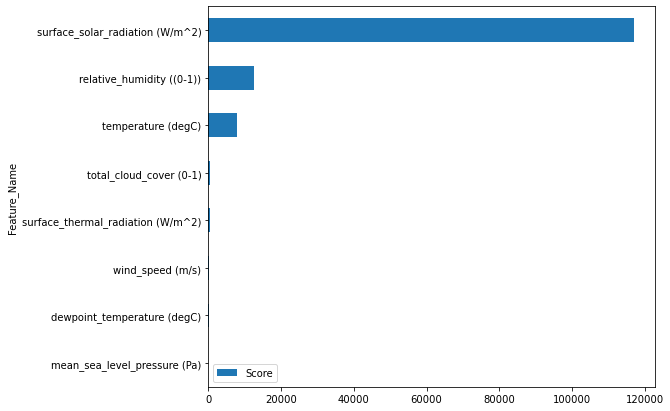

In [102]:
fea_solar_5 = feature_select(solar5,solar_5_test)
fea_solar_5

### Similar functions as above but applied to best-3-parameters model

In [103]:
def new_reg_model(model, solar_train, solar_test):
    '''Convenience function to fit an sklearn regression model and calculate the r2 score'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns
    
    X_train = solar_train[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    X_test = solar_test[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']
    
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

# Create a table of the various scores.
    results = pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return results

In [104]:
def new_reg_predicted(model, solar_train, solar_test):
    '''Output predictions'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns
    
    X_train = solar_train[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    X_test = solar_test[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']
    
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

    return testing_predictions

In [105]:
def compare(model,solar,solar_test):
    lin_solar_pred_old = reg_predicted(model,solar,solar_test)
    d = {'Predicted': lin_solar_pred_old, 'Actual': solar_test['power_output']}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    df = df.replace(df['Predicted'].loc[df['Predicted']<0].values[:],0)
    
    
    lin_solar_pred = new_reg_predicted(model,solar,solar_test)
    d5 = {'Predicted': lin_solar_pred, 'Actual': solar_test['power_output']}
    df5 = pd.DataFrame(data=d5)
    df5 = df5.reset_index(0)
    df5 = df5.replace(df5['Predicted'].loc[df5['Predicted']<0].values[:],0)
    
    
    #df = df.loc[df['timestamp']>"2020-11-15 00:00:00"]
    #df5 = df5.loc[df5['timestamp']>"2020-11-15 00:00:00"]

    
    
    plt.rcParams["figure.figsize"] = [20, 10]
    #plt.plot(df['timestamp'],df['Predicted'], color='green',label="Predicted_all_features")
    #plt.plot(df5['timestamp'],df5['Predicted'], color='red',label="Predicted_selected_features")
    #plt.plot(df5['timestamp'],df5['Actual'], color='blue',label="Actual")

    plt.plot(df5['Actual'],df['Predicted'],'r.',label="Predicted_all_features")
    plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")
    plt.plot(df5['Actual'],df5['Actual'], color='blue',label="Identity line")
    
    plt.legend()
    plt.title('Comparison between Predicted power_output of 2 RandomForest models')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    #plt.tick_params(axis='x', labelrotation = 45)
    plt.show()

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/639976051.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


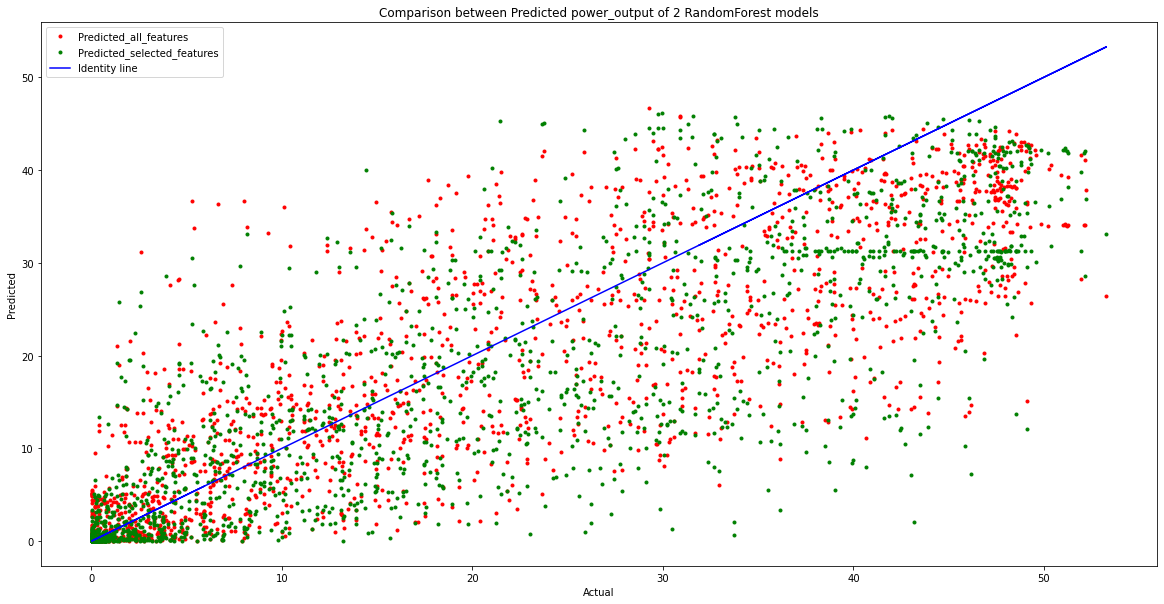

In [106]:
new_ran_0 = compare(RandomForestRegressor(),solar0,solar_0_test)
new_ran_0

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/639976051.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


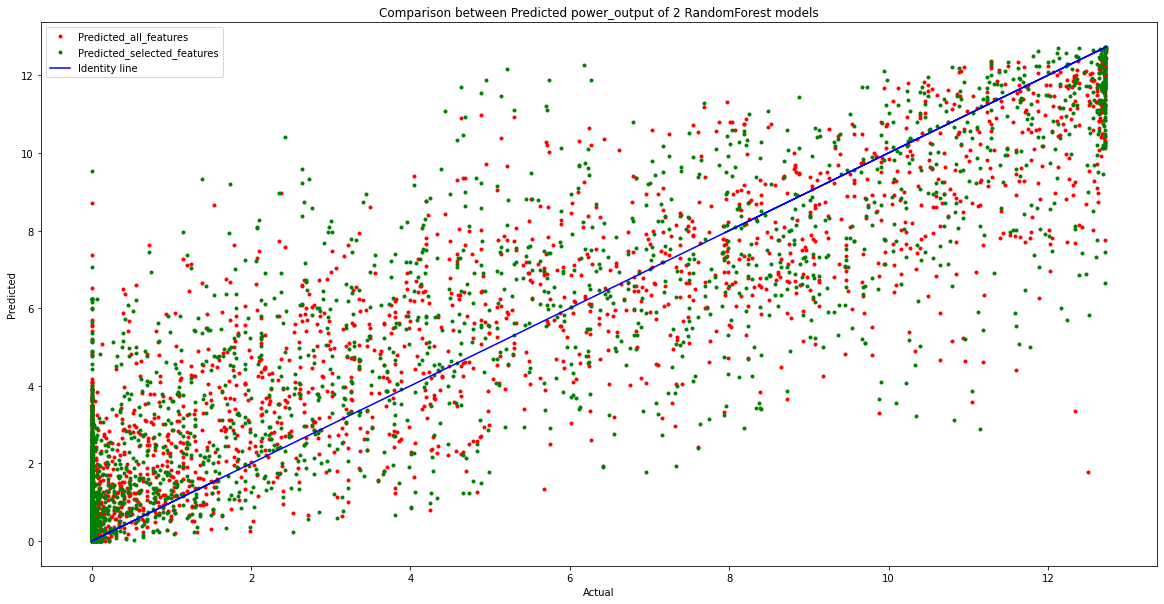

In [107]:
new_ran_1 = compare(RandomForestRegressor(),solar1,solar_1_test)
new_ran_1

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/639976051.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


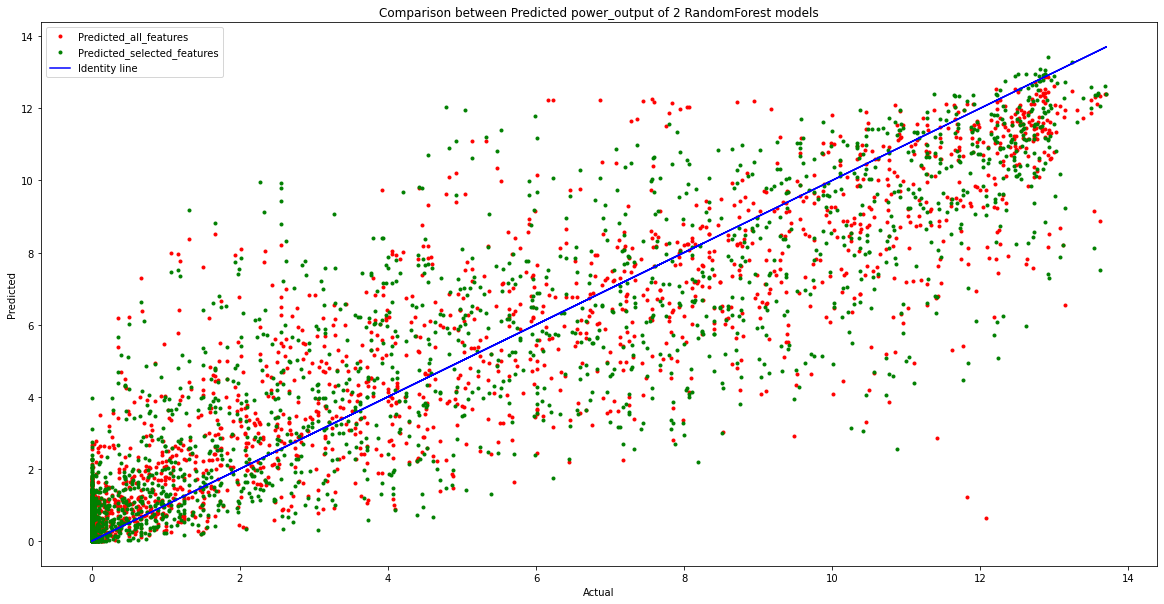

In [108]:
new_ran_2 = compare(RandomForestRegressor(),solar2,solar_2_test)
new_ran_2

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/639976051.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


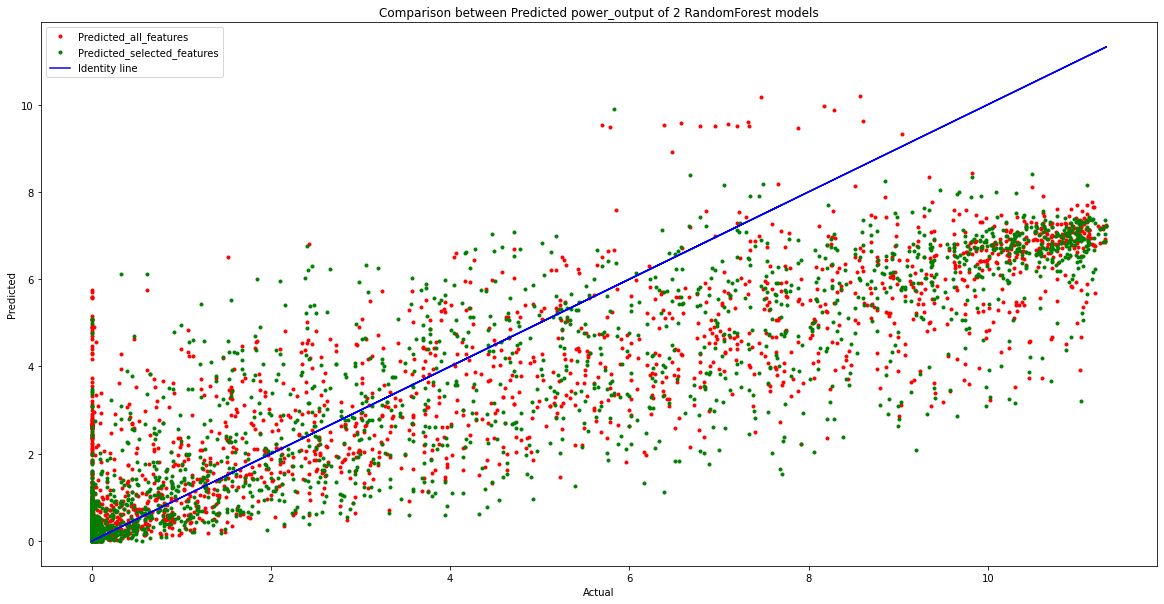

In [109]:
new_ran_3 = compare(RandomForestRegressor(),solar3,solar_3_test)
new_ran_3

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/639976051.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


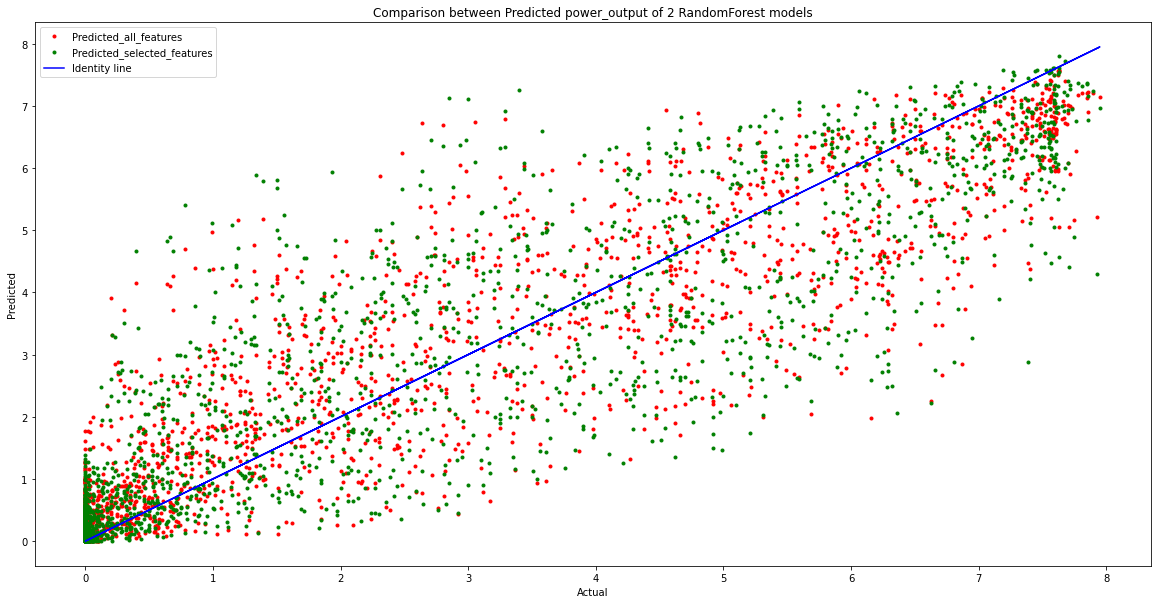

In [110]:
new_ran_4 = compare(RandomForestRegressor(),solar4,solar_4_test)
new_ran_4

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_7632/639976051.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


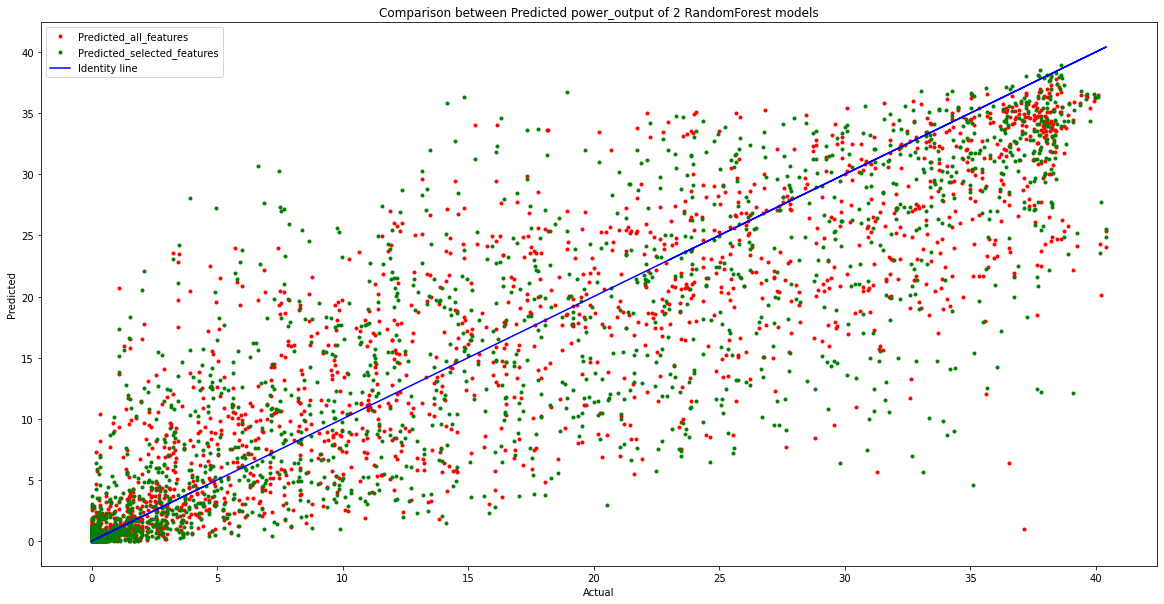

In [111]:
new_ran_5 = compare(RandomForestRegressor(),solar5,solar_5_test)
new_ran_5